## Global variables

In [1]:
redo_training = False

#path to pickle file
path_all_data = 'pickle_files/titanic_all_data_2020-01-07_12-27.pickle'
path_trees_estimators = 'pickle_files/titanic_trees_estimators_2020-01-08_13-00.pickle'

## Importing librairies

In [1]:
import sys,os,importlib

#Checking the packages version
!{sys.executable} -m pip install -r requirements.txt

#Adding path to custom module
module_path = os.path.abspath(os.path.join('python_files/'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Importing custom module
import utils

#If utils.py modified run this command  
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\ppike\\Documents\\GitHub Repositories\\Portfolio\\python_files\\utils.py'>

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

import sklearn, pickle, datetime
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif,f_classif

# Dataset description

In [4]:
titanic = pd.read_csv('datasets/titanic_dataset/train.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


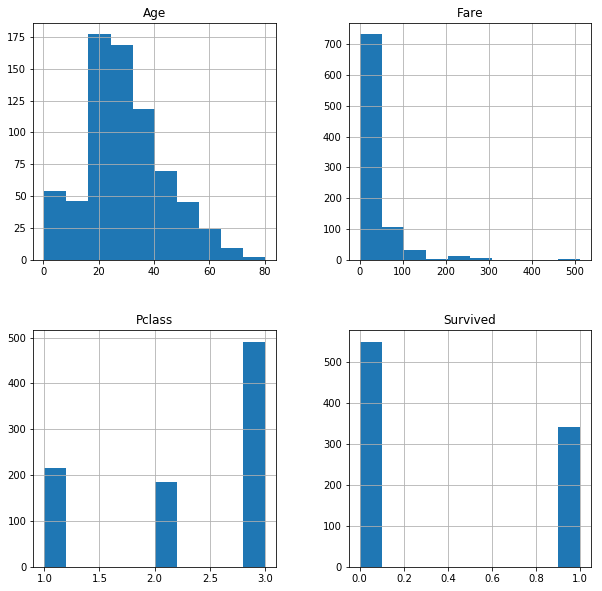

In [7]:
# Quick display of features using the hist function available for Dataframes
hist = titanic.hist(column=['Age','Survived','Fare','Pclass'],layout=(2,2),figsize=(10,10))

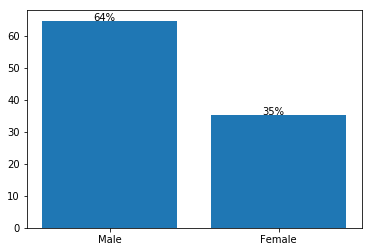

In [8]:
#Proper feature display
sex_count = titanic.Sex.value_counts()
sex_count = (sex_count/len(titanic))*100
plot = plt.bar(x =['Male','Female'],height = sex_count, label=['Female','Male'])

for i in plot.patches:
    plt.text(x =i.get_x()+0.3,y=i.get_height(),s = "{}{}".format(int(i.get_height()),'%'))

In [9]:
print("Percentage of values per feature:\n")
counts = titanic.count()
for col,t in zip(counts.index,counts):
    perc = (t/len(titanic))*100
    print(col,': ',round(perc,2),'%')

Percentage of values per feature:

PassengerId :  100.0 %
Survived :  100.0 %
Pclass :  100.0 %
Name :  100.0 %
Sex :  100.0 %
Age :  80.13 %
SibSp :  100.0 %
Parch :  100.0 %
Ticket :  100.0 %
Fare :  100.0 %
Cabin :  22.9 %
Embarked :  99.78 %


We are looking for missing values that could lead to biais.<br><br>
We can notice that a lot of values are missing for the Cabin feature, but we make the assumption that people with Nan values did not have Cabin. This features will be binarized in the preprocessing part.<br><br>
The Age feature is more problematic, because data was not entered. I have made the choice to replace missing values with the average age to not impact training and be able to use this feature. It is done in the preprocessing part. <br><br>
The missing values for the Embarked feature is negligible because less than 1%.

In [10]:
drop_col = []

for col in titanic.columns:
    try:
        print(col,len(np.unique(titanic[col].values)))
        if titanic.shape[0] == len(np.unique(titanic[col].values)):
            drop_col.append(col)
    except:
        print('---Error with column: ',col)
            
#titanic.drop(columns=drop_col,inplace=True)
print('\n \nColumns: ',drop_col,' were deleted')

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 265
SibSp 7
Parch 7
Ticket 681
Fare 248
---Error with columns:  Cabin
---Error with columns:  Embarked

 
Columns:  ['PassengerId', 'Name']  were deleted


Features with one value per individuals are deleted because they will not bring any information to the models.

# Dataset preprocessing

In [11]:
titanic_int = titanic[['Pclass','Age','SibSp','Parch','Fare','Cabin']]
survived = titanic['Survived']

In [12]:
#Binarizing Sex feature
lb = preprocessing.LabelBinarizer()
lb = lb.fit_transform(titanic['Sex'])
titanic_int['Sex'] = lb

#Categorizing Embarked feature
titanic_int['Embarked'] = pd.Categorical(pd.factorize(titanic.Embarked)[0])#nan values in embarked are labelized as -1
titanic_int.head()

C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked
0,3,22.0,1,0,7.2500,NaN,1,0
1,1,38.0,1,0,71.2833,C85,0,1
2,3,26.0,0,0,7.9250,NaN,0,0
3,1,35.0,1,0,53.1000,C123,0,0
4,3,35.0,0,0,8.0500,NaN,1,0


In [13]:
#Replacing Nan values by mean for Age feature
nan = titanic_int.isna()

nan_age = nan[nan.Age == True]
titanic_int.loc[nan_age.index,'Age']  = np.mean(titanic_int['Age'])

#Setting Cabin feature to binary
nan_cabin = nan[nan.Cabin == True]
titanic_int['Cabin'] = 1
titanic_int.loc[nan_cabin.index,'Cabin'] = 0

titanic_int.head()

C:\Users\ppike\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ppike\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked
0,3,22.0,1,0,7.2500,0,1,0
1,1,38.0,1,0,71.2833,1,0,1
2,3,26.0,0,0,7.9250,0,0,0
3,1,35.0,1,0,53.1000,1,0,0
4,3,35.0,0,0,8.0500,0,1,0


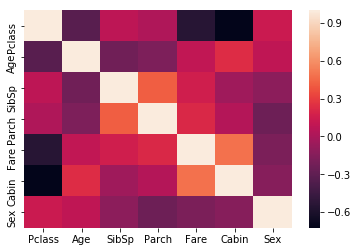

In [14]:
#Computing correlation matrix between features
corr_m = titanic_int.corr()
sns.heatmap(corr_m)

With this correlation matrix we can see that:
- feature Parch (parent and children) and SibSp (sibling and spouses) are correlated, it seems coherent because people how had siblings aboard were likely to have their parents with them or people how came with their spouses were likely to have children
- feature Cabin and Fare are correlated, it seems coherent that if you had a Cabin your ticket would be more expensive
- feature Cabin is anti-correlated with Pclass, it seems that only the highest class had cabins

In [15]:
survived = np.array(survived)
titanic_arr = np.array(titanic_int)

#Developp on choosing the right scaler
titanic_arr = preprocessing.scale(titanic_arr)

# Model selection

In [16]:
from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree

import sklearn.metrics as metrics

In [17]:
X = titanic_arr
y = survived
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

In [18]:
names = ['knc','svc','dtc','rfc','mlpc','abc','gnb','qda','sgdc','bc','etc','gbc','hgbc']

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    #GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier()]

parameters = [
    {'weights':('uniform','distance'),'algorithm':('ball_tree','kd_tree','brute'),'leaf_size':range(10,51)},
    {'kernel':('linear','poly','rbf','sigmoid'),'degree':range(1,6),'decision_function_shape':('ovo','ovr')},
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'activation':('identity','logistic','tanh','relu'),'solver':('lbfgs','sgd','adam'),\
              'learning_rate':('constant','invscaling','adaptive')},
    {'n_estimators':range(40,60),'algorithm':('SAMME','SAMME.R'),'learning_rate':np.arange(0.1,1.1,0.1)},
    {'var_smoothing': np.arange(1e-9,10e-7,1e-8)},
    {'store_covariance':(True,False),'tol': np.arange(1e-4,1.0,1e-4)},
    {'loss':('hinge','log','modified_huber','squared_hinge','perceptron','squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'),\
             'penalty':('none','l2','l1','elasticnet'),'fit_intercept':(True,False),'shuffle':(True,False)},
    {'n_estimators':range(5,15),'bootstrap_features':(True,False),'oob_score':(True,False)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)},
    {'loss':('deviance','exponential'),'learning_rate':np.arange(0.1,1.1,0.1),'criterion':('friedman_mse','mse','mae'),'max_features':('auto','sqrt','log2')},
    {'loss':('auto','binary_crossentropy','categorical_crossentropy'),'learning_rate':np.arange(0.1,1.1,0.1)}
]

best_estimators = []
all_data = []


In [19]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_estimators.append((name,clf.best_estimator_))
        all_data.append(clf)
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    utils.save_to_pickle(all_data,'titanic_all_data')
    
else:
    all_data = pickle.load(open(path_all_data,'rb'))

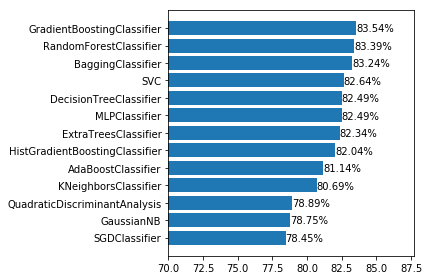

In [20]:
scores = []
names = []

for clf in all_data:
    scores.append(clf.best_score_)
    names.append(str(clf.best_estimator_).split('(')[0])

utils.plot_scores(scores,names)


In [21]:
estimators = []

for data,name in zip(all_data,names):
    estimators.append((name,data.best_estimator_))

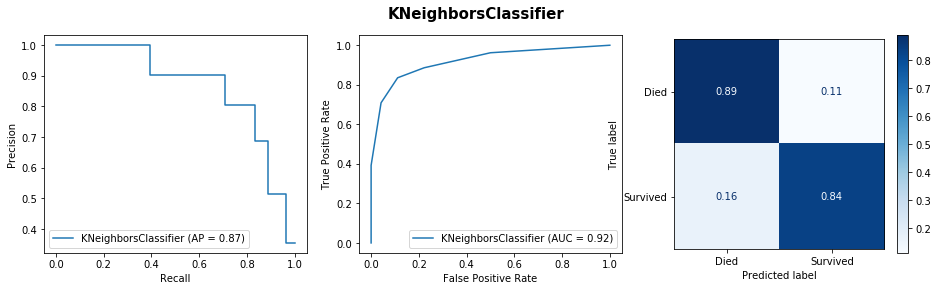

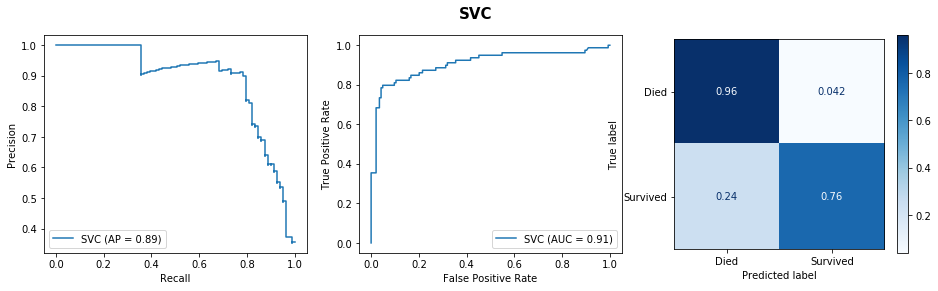

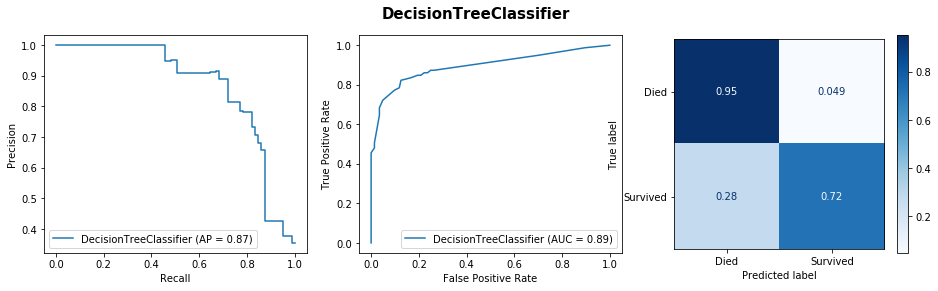

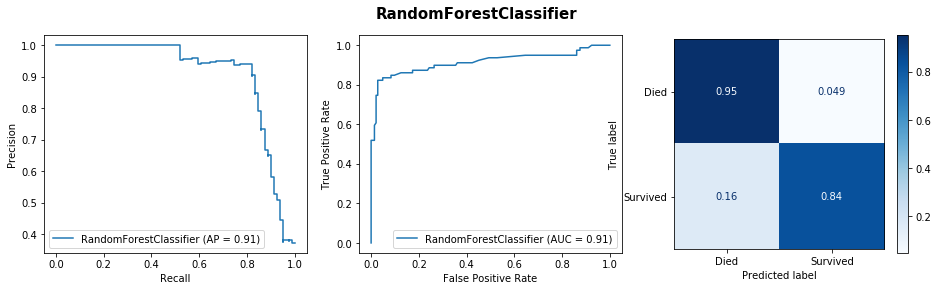

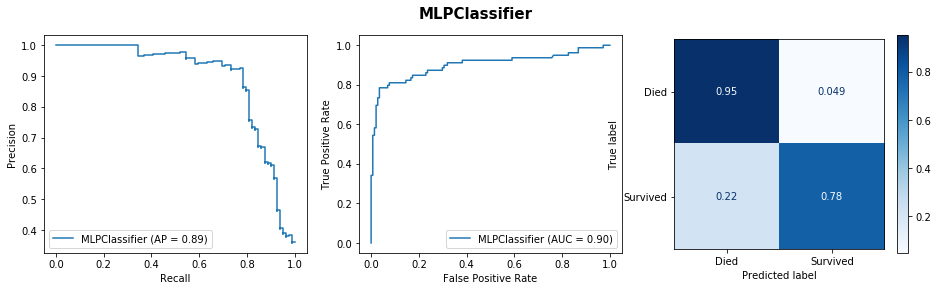

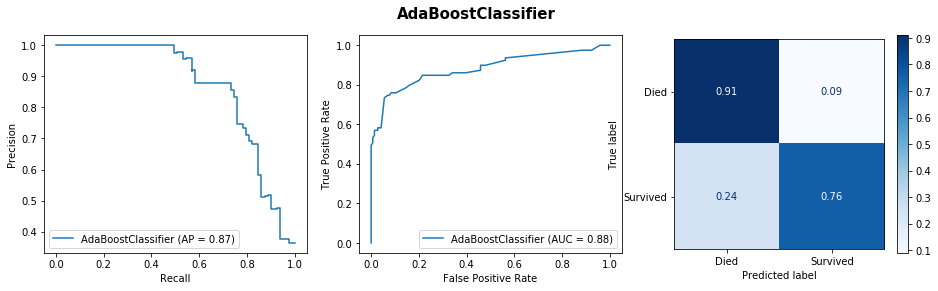

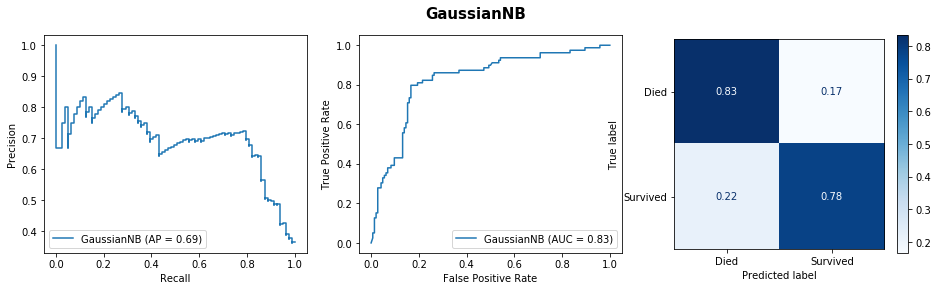

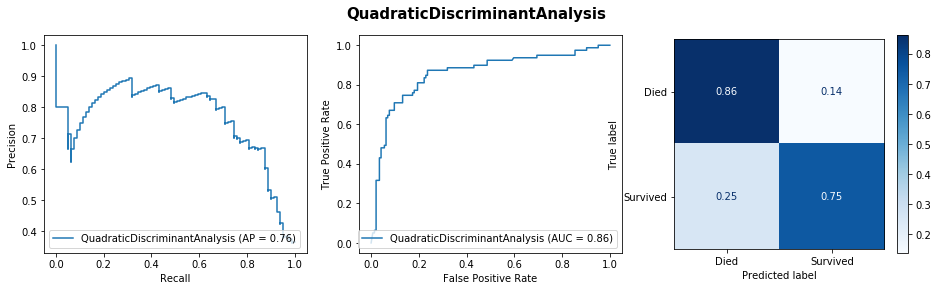

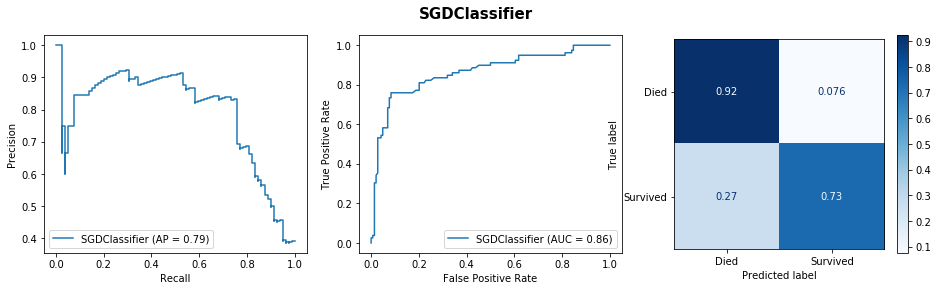

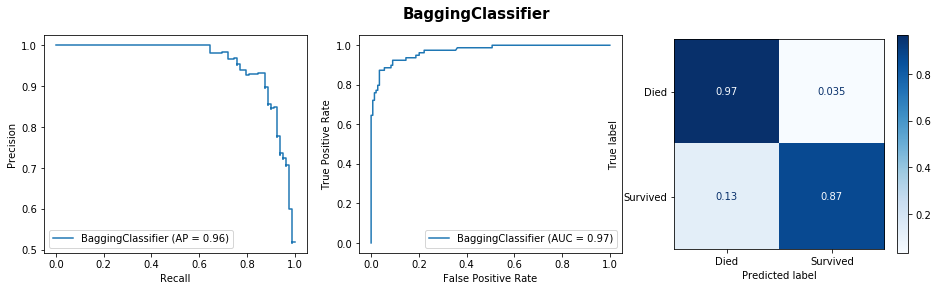

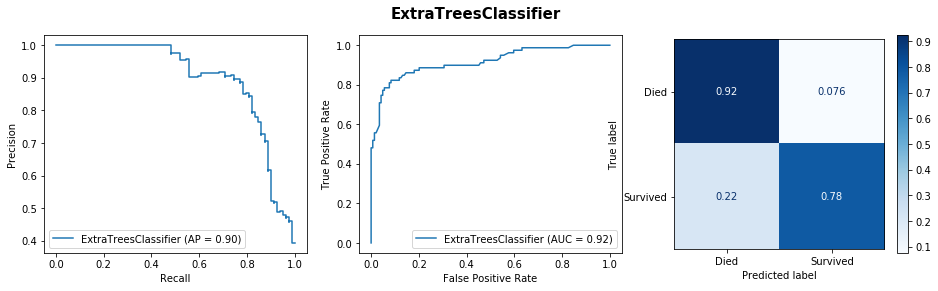

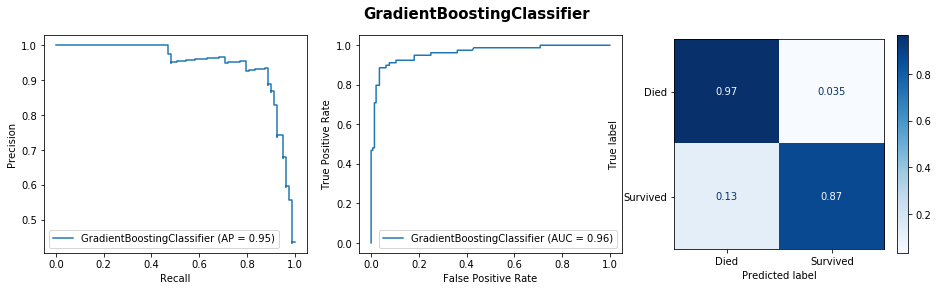

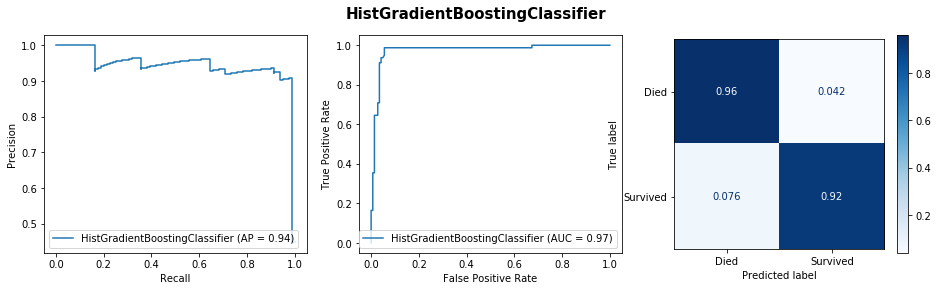

In [22]:
for clf in estimators:
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
    
    fig.suptitle(clf[0],fontsize=15,fontweight='bold')
    clf = clf[1]
    
    metrics.plot_precision_recall_curve(clf,X_test,y_test,ax=ax1)    
    metrics.plot_roc_curve(clf,X_test,y_test,ax=ax2)
    metrics.plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',display_labels=['Died','Survived'],ax=ax3)

Looking at the confusion matrices we can see that even if all the models have an accuracy above 85% a lot of them struggles to predict quitting customers.<br><br>
We want the model with the highest true positive rate (bottom right cell). In our case it is the HistGradientBoostingClassifier.<br>

__Precision-Recall curve__

The Precision-Recall curve represents the average precision for every recall value measured.<br>
Reminder:
- Precision = True Positive / (True Positive + False Positive)
- Recall = True Positive / (True Positive + False Negative)

The Average Precision (AP) summarizes the Precision-Recall curve. It is between 0 and 1. The more is the better, meaning a classifier with a AP of one is a excellent classifier.<br>

__ROC curve__

The receiver operating characteristic (ROC) curve represents the true positives rate as a function of the false positives rate.
- True Positive Rate = Recall
- False Positive Rate = False Positive / (False Positive + True Negative)

The Area Under the Curve (AUC) summarizes the ROC curve. As indicated by his name it represents the area under the ROC curve. This metrics is also between 0 and 1. The more is the better.<br><br>

Good classifiers would have these curves (Recall-Precision and ROC) making right angle.

## Voting classifier

C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


accuracy_score 0.852017937219731
balanced_accuracy_score 0.8400912996777659
average_precision_score 0.6870180716592525


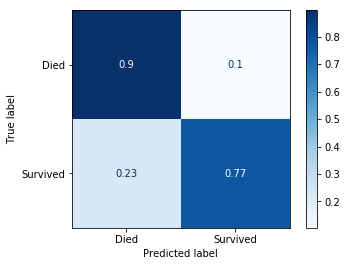

In [23]:
voting_clf = VotingClassifier(estimators)
voting_clf.fit(X_train,y_train)
predictions = voting_clf.predict(X_test)

print('accuracy_score',metrics.accuracy_score(predictions,y_test))
print('balanced_accuracy_score',metrics.balanced_accuracy_score(predictions,y_test))
print('average_precision_score',metrics.average_precision_score(predictions,y_test))

metrics.plot_confusion_matrix(voting_clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',display_labels=['Died','Survived'])


The voting classifier is an ensemble method. It is using the previously trained models to make predicitons. We can notice that it has improved the accuracy_score. It will be the selected model.

# Focusing on trees

In [24]:
names = ['dtc','rfc','etc']

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    ExtraTreesClassifier(n_estimators=10)]

parameters = [
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)}
]

best_trees_estimators = []

In [25]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_trees_estimators.append((name,clf.best_estimator_))
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    utils.save_to_pickle(best_trees_estimators,'titanic_trees_estimators')

else:
    best_trees_estimators = pickle.load(open(path_trees_estimators,'rb'))

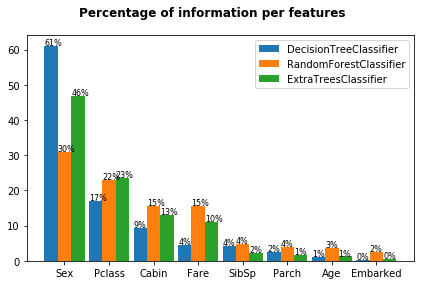

In [26]:
fig,axis = plt.subplots()
fig.suptitle('Percentage of information per features',fontweight='bold')


x = np.arange(len(titanic_int.columns)*3,step =3)  # the label locations
width = 0.9  # the width of the bars

n = 0 
axis.set_xticks(x)


for clf in best_trees_estimators:
    coord = x + n*width
    n = n+1
    
    feature_importance = pd.DataFrame(index=titanic_int.columns)
    name = str(clf[1]).split('(')[0]
    names.append(name)
    
    clf = clf[1]
    clf = clf.fit(X_train,y_train)
    
    feature_importance['Percentage']= clf.feature_importances_ * 100
    feature_importance.sort_values(by='Percentage',inplace=True,ascending=False)
    
    axis.bar(x = coord,tick_label=feature_importance.index,height=feature_importance['Percentage'],width=width,label=name)

    
for i in axis.patches:
    axis.text(x = i.get_x(),y = i.get_height()+0.2,s = "{}{}".format(int(i.get_height()),'%'),fontsize=8)
    

plt.xticks(x+width)
axis.legend()

plt.tight_layout(rect=[0, 0, 1,0.93])

We can notice that for the DecisionTreeClassifier and the ExtraTreesClassifier the Sex feature brings more than half of the information. The information on the RandomForestClassifier is spread on more features.